# Summary
This code trains and evaluates a Random Forest Classifier to predict deforestation events based on land use and tree cover data. The input data consists of a stack of raster files, including land use plans, tree cover, and historical deforestation data. The model uses these raster files to predict deforestation events for the year 2012.

The input raster data is flattened and stacked into a single 2D array, X_flat. `NoData` values are removed from the input data (X_cleaned) and the target variable (y_cleaned) before splitting them into training and testing datasets.

The Random Forest Classifier is trained using the X_train and y_train datasets, and its performance is evaluated using cross-validation. The trained model is then used to predict deforestation events for the testing dataset (X_test). The model's performance is assessed using confusion matrices and classification reports for both the training and testing datasets.

Finally, the feature importances of the input variables (e.g., land use plans, tree cover) are calculated and visualized in a bar chart to understand the relative importance of each input variable in predicting deforestation events.

# Import Libraries and Constants

In [1]:
import os
import re
import sys
import numpy as np
import pandas as pd
import tempfile
import shutil
import matplotlib.pyplot as plt
import rasterio

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, 
                             precision_score, recall_score, f1_score, roc_auc_score, 
                             precision_recall_curve, roc_curve, auc)
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     GridSearchCV, RandomizedSearchCV)
from scipy.stats import randint as sp_randint

from imblearn.ensemble import BalancedRandomForestClassifier
import joblib
from joblib import dump


In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Get the current working directory
current_dir = os.path.abspath('')

# Search for the 'constants.py' file starting from the current directory and moving up the hierarchy
project_root = current_dir
while not os.path.isfile(os.path.join(project_root, 'constants.py')):
    project_root = os.path.dirname(project_root)

# Add the project root to the Python path
sys.path.append(project_root)



In [4]:
from constants import SERVER_PATH, OUTPUT_PATH, MASKED_RASTERS_DIR, FEATURES_DIR


In [5]:
#output- update this for subsequent runs
output_folder = os.path.join(OUTPUT_PATH[0], 'brfc-features-model')




# Create Stack

In [6]:
# helper function to read tiff files
def read_tiff_image(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1)


In [7]:
# List of paths to the raster files excluding 'deforestation11_20_masked.tif'
feature_files = [os.path.join(FEATURES_DIR[0], file_name) for file_name in os.listdir(FEATURES_DIR[0])]

# Then you can use this list of raster_files to create feature_data_arrays and raster_data_flat:
feature_data_arrays = [read_tiff_image(file_path) for file_path in feature_files]
feature_data_flat = [data_array.flatten() for data_array in feature_data_arrays]

# Path to the y_file
y_file = os.path.join(MASKED_RASTERS_DIR[0], 'deforestation11_20_masked.tif')


In [8]:
feature_files

['/Users/romero61/../../capstone/pyforest/ml_data/output/tree_masked_rasters/soil_treemask.tif',
 '/Users/romero61/../../capstone/pyforest/ml_data/output/tree_masked_rasters/road_treemask.tif',
 '/Users/romero61/../../capstone/pyforest/ml_data/output/tree_masked_rasters/lup_10_treemask.tif',
 '/Users/romero61/../../capstone/pyforest/ml_data/output/tree_masked_rasters/precipitation_treemask.tif',
 '/Users/romero61/../../capstone/pyforest/ml_data/output/tree_masked_rasters/river_treemask.tif',
 '/Users/romero61/../../capstone/pyforest/ml_data/output/tree_masked_rasters/cities_treemask.tif',
 '/Users/romero61/../../capstone/pyforest/ml_data/output/tree_masked_rasters/ports_treemask.tif']

In [18]:
y_file

'/Users/romero61/../../capstone/pyforest/ml_data/output/masked_rasters/deforestation11_20_masked.tif'

In [10]:
# Find the dimensions of all the raster data arrays
raster_shapes = [raster_data.shape for raster_data in feature_data_arrays]

# Check if all raster data arrays have the same dimensions
if len(set(raster_shapes)) > 1:
    print("There are mismatching dimensions:")
    for file_path, raster_shape in zip(raster_files, raster_shapes):
        print(f"File: {file_path}, Shape: {raster_shape}")
else:
    print("All raster data arrays have the same dimensions.")
    # Check the dimensions of all the raster data arrays
    for i, data_array in enumerate(feature_data_arrays):
        print(f"Raster {i}: {data_array.shape}")


All raster data arrays have the same dimensions.
Raster 0: (22512, 20381)
Raster 1: (22512, 20381)
Raster 2: (22512, 20381)
Raster 3: (22512, 20381)
Raster 4: (22512, 20381)
Raster 5: (22512, 20381)
Raster 6: (22512, 20381)


# Stack and Flatten Data

In [11]:
# NoData Value
no_data_value = -1

# Stack the flattened raster data
X_flat = np.column_stack(feature_data_flat)

# Use the y_file obtained from the find_deforestation_file function
y = read_tiff_image(y_file).flatten()

# Remove rows with NoData values
'''checks each row in X_flat and creates a boolean array (valid_rows_X) that has the same number of elements 
as the number of rows in X_flat. Each element in valid_rows_X is True if there is no NoData value in 
the corresponding row of X_flat and False otherwise.'''
valid_rows_X = ~(X_flat == no_data_value).any(axis=1)

'''checks each element in the y array and creates a boolean array (valid_rows_y) that has the same number of 
elements as y. Each element in valid_rows_y is True if the corresponding element in y is not 
equal to the NoData value and False otherwise.'''
valid_rows_y = y != no_data_value

'''checks each element in the y array and creates a boolean array (valid_rows_y) 
that has the same number of elements as y. Each element in valid_rows_y is True if the corresponding element 
in y is not equal to the NoData value and False otherwise.'''
valid_rows = valid_rows_X & valid_rows_y

'''creates a new array X_cleaned by selecting only the rows in X_flat that 
correspond to the True elements in valid_rows.'''
X_cleaned = X_flat[valid_rows]

'''creates a new array y_cleaned by selecting only the elements in y that correspond 
to the True elements in valid_rows.'''
y_cleaned = y[valid_rows]
 

To ensure your data cleaning steps have been applied correctly, you can check the following:

**NoData values have been removed:** You should confirm that there are no NoData values in your cleaned data. This can be done by asserting that there are no occurrences of no_data_value in X_cleaned and y_cleaned.

In [12]:
assert not (X_cleaned == no_data_value).any()
assert not (y_cleaned == no_data_value).any()


These assertions will throw an error if there is a NoData value in X_cleaned or y_cleaned

**Dimensions are correct:** The shapes of X_cleaned and y_cleaned should match along the row dimension (the first dimension for 2D array X_cleaned and the only dimension for 1D array y_cleaned).

In [13]:
print("Shape of X_cleaned:", X_cleaned.shape)
print("Shape of y_cleaned:", y_cleaned.shape)


Shape of X_cleaned: (29112890, 7)
Shape of y_cleaned: (29112890,)


Make sure the number of rows in X_cleaned equals the number of elements in y_cleaned.

**Confirm that the valid rows have been correctly identified:** You can do this by checking that the number of True values in valid_rows equals the number of rows in X_cleaned (or the number of elements in y_cleaned).

In [14]:
assert valid_rows.sum() == X_cleaned.shape[0]


# Split the data into training and testing sets


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.3, random_state=42, stratify=y_cleaned)


In [16]:
print("Shape of y_test:", y_test.shape)


Shape of y_test: (8733867,)


# Class Balance Check

In [17]:
# Create pandas Series from your labels
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)
y_cleaned_series = pd.Series(y_cleaned)

# Print balance of classes in training, testing, and whole dataset
print("Training data balance:\n", y_train_series.value_counts(normalize=True))
print("Testing data balance:\n", y_test_series.value_counts(normalize=True))
print("Whole dataset balance:\n", y_cleaned_series.value_counts(normalize=True))


Training data balance:
 0    0.747872
1    0.252128
dtype: float64
Testing data balance:
 0    0.747872
1    0.252128
dtype: float64
Whole dataset balance:
 0    0.747872
1    0.252128
dtype: float64


SOIL Value: 0.0, Count: 37731
SOIL Value: 4.0, Count: 83618
SOIL Value: 6.0, Count: 210035
SOIL Value: 10.0, Count: 1008873
SOIL Value: 11.0, Count: 14349919
SOIL Value: 12.0, Count: 497698
SOIL Value: 15.0, Count: 3987
SOIL Value: 16.0, Count: 47218
SOIL Value: 17.0, Count: 24247
SOIL Value: 18.0, Count: 1373366
SOIL Value: 20.0, Count: 133
SOIL Value: 21.0, Count: 4196784
SOIL Value: 22.0, Count: 92
SOIL Value: 25.0, Count: 64
SOIL Value: 26.0, Count: 5416677
SOIL Value: 29.0, Count: 1862448
-----------------


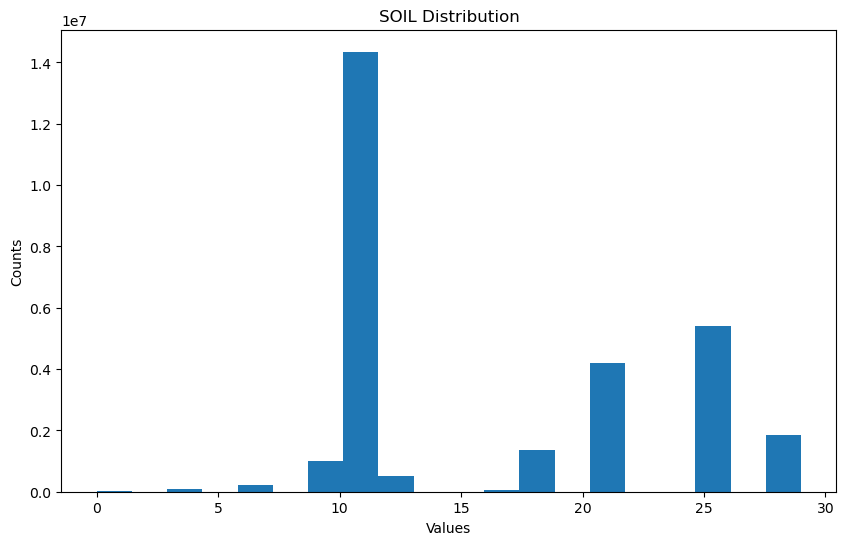

ROAD Value: 0.0, Count: 225402
ROAD Value: 1.0, Count: 147340
ROAD Value: 2.0, Count: 146223
ROAD Value: 3.0, Count: 125058
ROAD Value: 4.0, Count: 122931
ROAD Value: 5.0, Count: 140458
ROAD Value: 6.0, Count: 120964
ROAD Value: 7.0, Count: 127205
ROAD Value: 8.0, Count: 130431
ROAD Value: 9.0, Count: 122226
ROAD Value: 10.0, Count: 119709
ROAD Value: 11.0, Count: 116467
ROAD Value: 12.0, Count: 122583
ROAD Value: 13.0, Count: 126116
ROAD Value: 14.0, Count: 118307
ROAD Value: 15.0, Count: 115603
ROAD Value: 16.0, Count: 116768
ROAD Value: 17.0, Count: 117861
ROAD Value: 18.0, Count: 119198
ROAD Value: 19.0, Count: 114822
ROAD Value: 20.0, Count: 112816
ROAD Value: 21.0, Count: 119020
ROAD Value: 22.0, Count: 111240
ROAD Value: 23.0, Count: 111504
ROAD Value: 24.0, Count: 112744
ROAD Value: 25.0, Count: 117657
ROAD Value: 26.0, Count: 113856
ROAD Value: 27.0, Count: 107657
ROAD Value: 28.0, Count: 108533
ROAD Value: 29.0, Count: 113140
ROAD Value: 30.0, Count: 108114
ROAD Value: 31.0, 

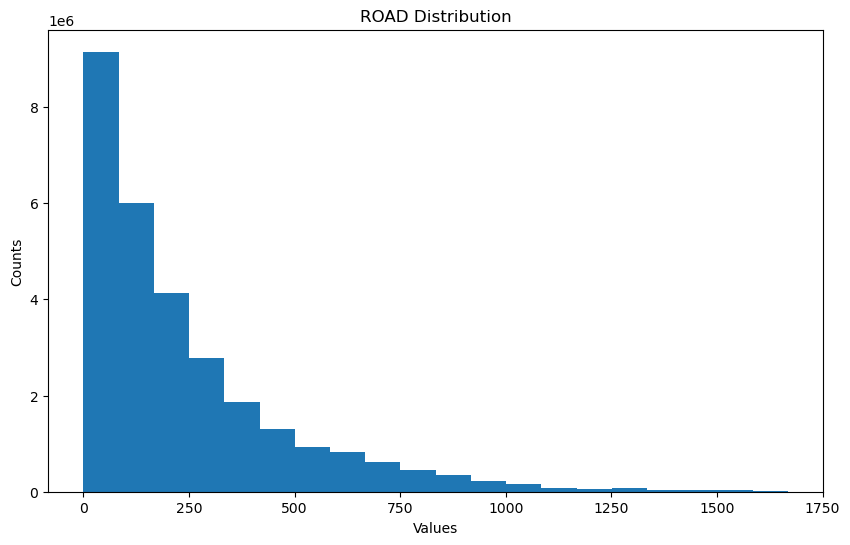

LUP_10 Value: 1.0, Count: 4156080
LUP_10 Value: 2.0, Count: 12844684
LUP_10 Value: 3.0, Count: 11556539
LUP_10 Value: 4.0, Count: 555587
-----------------


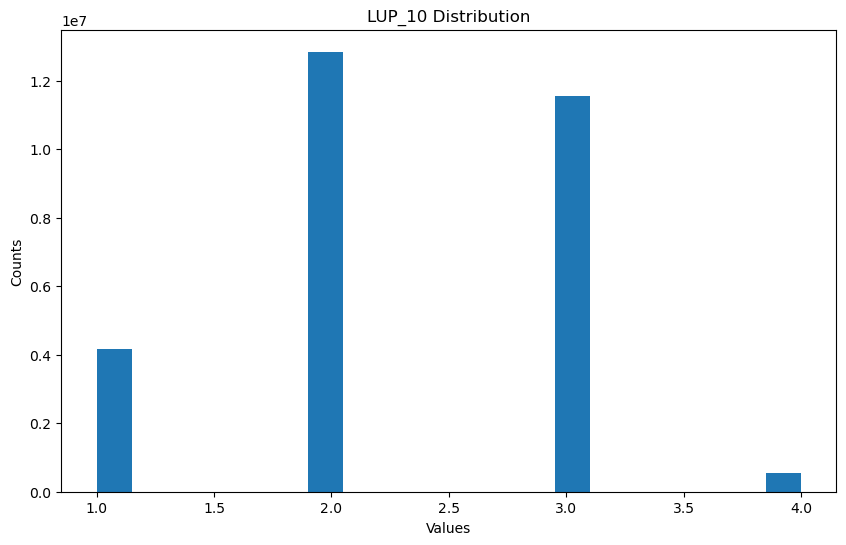

PRECIPITATION Value: 0.0, Count: 769
PRECIPITATION Value: 353.0, Count: 3031
PRECIPITATION Value: 356.0, Count: 2940
PRECIPITATION Value: 358.0, Count: 41777
PRECIPITATION Value: 363.0, Count: 990
PRECIPITATION Value: 372.0, Count: 14195
PRECIPITATION Value: 375.0, Count: 32931
PRECIPITATION Value: 377.0, Count: 12556
PRECIPITATION Value: 381.0, Count: 15561
PRECIPITATION Value: 388.0, Count: 5930
PRECIPITATION Value: 390.0, Count: 33916
PRECIPITATION Value: 394.0, Count: 1
PRECIPITATION Value: 409.0, Count: 18794
PRECIPITATION Value: 414.0, Count: 16265
PRECIPITATION Value: 415.0, Count: 708
PRECIPITATION Value: 421.0, Count: 2110
PRECIPITATION Value: 432.0, Count: 9114
PRECIPITATION Value: 434.0, Count: 6686
PRECIPITATION Value: 442.0, Count: 8160
PRECIPITATION Value: 443.0, Count: 10097
PRECIPITATION Value: 451.0, Count: 173
PRECIPITATION Value: 452.0, Count: 14961
PRECIPITATION Value: 459.0, Count: 5140
PRECIPITATION Value: 461.0, Count: 8179
PRECIPITATION Value: 462.0, Count: 1145

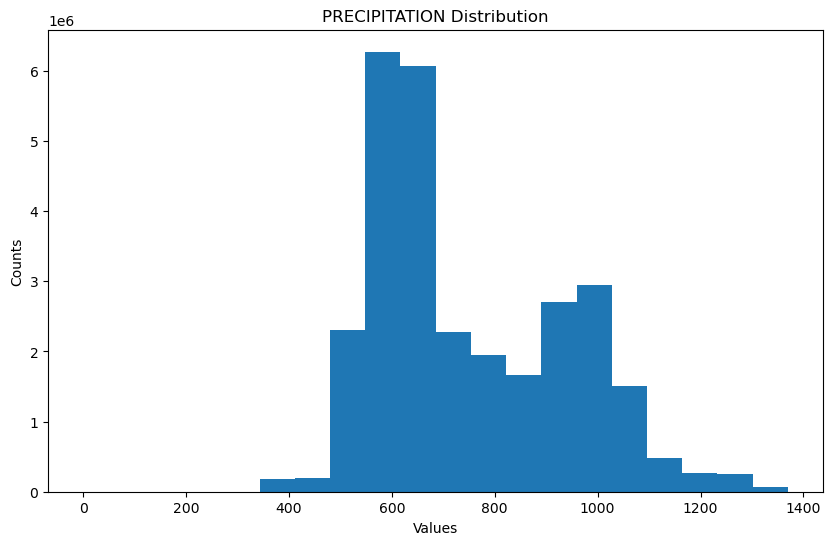

RIVER Value: 0.0, Count: 123370
RIVER Value: 1.0, Count: 80578
RIVER Value: 2.0, Count: 79574
RIVER Value: 3.0, Count: 57096
RIVER Value: 4.0, Count: 55904
RIVER Value: 5.0, Count: 76056
RIVER Value: 6.0, Count: 54553
RIVER Value: 7.0, Count: 63828
RIVER Value: 8.0, Count: 65507
RIVER Value: 9.0, Count: 59504
RIVER Value: 10.0, Count: 58894
RIVER Value: 11.0, Count: 53794
RIVER Value: 12.0, Count: 62412
RIVER Value: 13.0, Count: 64784
RIVER Value: 14.0, Count: 58380
RIVER Value: 15.0, Count: 56185
RIVER Value: 16.0, Count: 56619
RIVER Value: 17.0, Count: 60097
RIVER Value: 18.0, Count: 58768
RIVER Value: 19.0, Count: 56582
RIVER Value: 20.0, Count: 53584
RIVER Value: 21.0, Count: 60950
RIVER Value: 22.0, Count: 51962
RIVER Value: 23.0, Count: 51794
RIVER Value: 24.0, Count: 54274
RIVER Value: 25.0, Count: 57431
RIVER Value: 26.0, Count: 56160
RIVER Value: 27.0, Count: 49323
RIVER Value: 28.0, Count: 49289
RIVER Value: 29.0, Count: 54962
RIVER Value: 30.0, Count: 49982
RIVER Value: 31.0

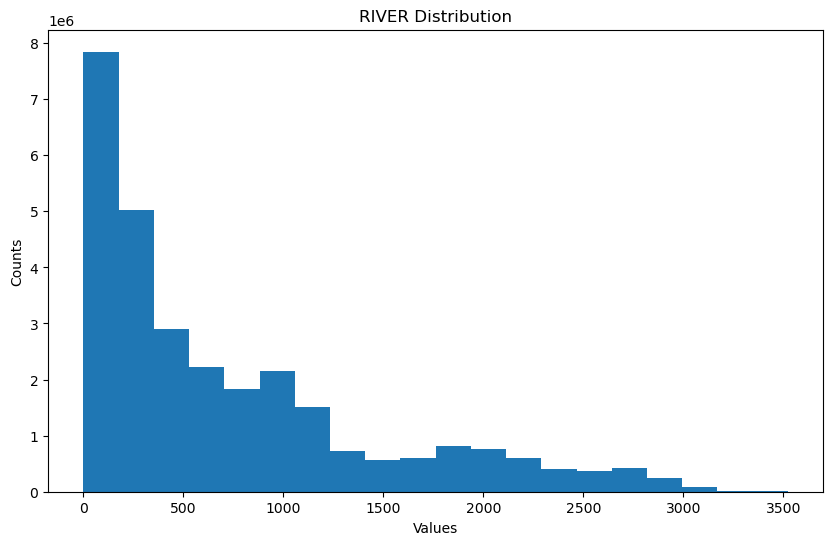

CITIES Value: 6.0, Count: 162
CITIES Value: 7.0, Count: 694
CITIES Value: 8.0, Count: 1754
CITIES Value: 9.0, Count: 2867
CITIES Value: 10.0, Count: 3335
CITIES Value: 11.0, Count: 6002
CITIES Value: 12.0, Count: 4908
CITIES Value: 13.0, Count: 7057
CITIES Value: 14.0, Count: 7365
CITIES Value: 15.0, Count: 9012
CITIES Value: 16.0, Count: 5721
CITIES Value: 17.0, Count: 8693
CITIES Value: 18.0, Count: 9199
CITIES Value: 19.0, Count: 10374
CITIES Value: 20.0, Count: 11471
CITIES Value: 21.0, Count: 17794
CITIES Value: 22.0, Count: 13557
CITIES Value: 23.0, Count: 12816
CITIES Value: 24.0, Count: 10984
CITIES Value: 25.0, Count: 9663
CITIES Value: 26.0, Count: 12585
CITIES Value: 27.0, Count: 10516
CITIES Value: 28.0, Count: 11919
CITIES Value: 29.0, Count: 11899
CITIES Value: 30.0, Count: 10669
CITIES Value: 31.0, Count: 10825
CITIES Value: 32.0, Count: 10311
CITIES Value: 33.0, Count: 7894
CITIES Value: 34.0, Count: 17832
CITIES Value: 35.0, Count: 17320
CITIES Value: 36.0, Count: 1758

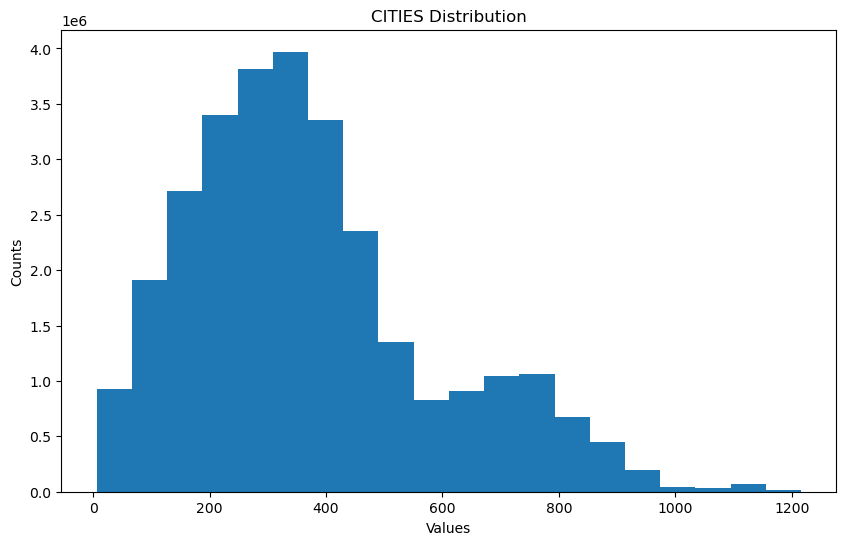

PORTS Value: 29.0, Count: 408
PORTS Value: 30.0, Count: 3
PORTS Value: 31.0, Count: 262
PORTS Value: 32.0, Count: 466
PORTS Value: 33.0, Count: 256
PORTS Value: 34.0, Count: 628
PORTS Value: 35.0, Count: 756
PORTS Value: 36.0, Count: 1024
PORTS Value: 37.0, Count: 960
PORTS Value: 38.0, Count: 900
PORTS Value: 39.0, Count: 1169
PORTS Value: 40.0, Count: 231
PORTS Value: 41.0, Count: 2275
PORTS Value: 42.0, Count: 549
PORTS Value: 43.0, Count: 1366
PORTS Value: 44.0, Count: 341
PORTS Value: 45.0, Count: 182
PORTS Value: 46.0, Count: 288
PORTS Value: 47.0, Count: 865
PORTS Value: 48.0, Count: 73
PORTS Value: 49.0, Count: 1223
PORTS Value: 50.0, Count: 694
PORTS Value: 51.0, Count: 1452
PORTS Value: 52.0, Count: 1898
PORTS Value: 54.0, Count: 2707
PORTS Value: 55.0, Count: 564
PORTS Value: 56.0, Count: 2718
PORTS Value: 57.0, Count: 415
PORTS Value: 58.0, Count: 632
PORTS Value: 59.0, Count: 1030
PORTS Value: 60.0, Count: 2657
PORTS Value: 61.0, Count: 1563
PORTS Value: 62.0, Count: 226
P

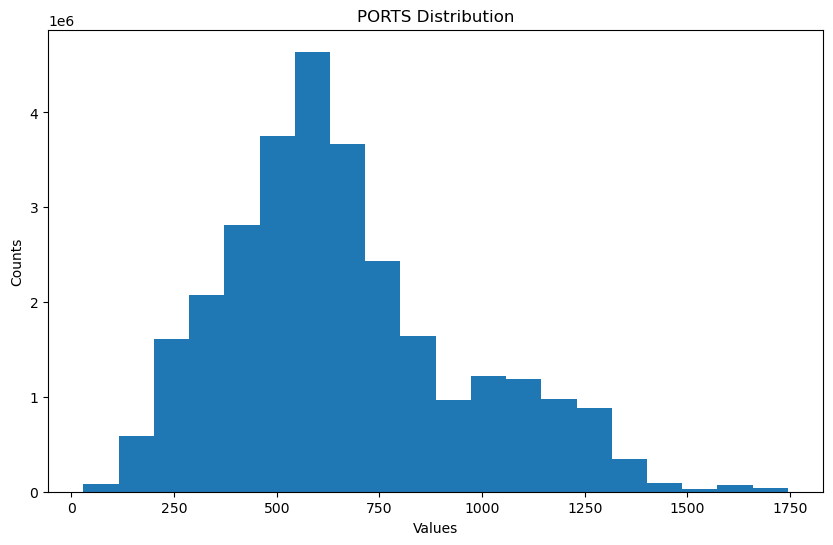

In [19]:
# Create a list to hold your feature file paths


# Define the labels for your features
feature_labels = [ 'SOIL', 'ROAD', 'LUP_10', 'PRECIPITATION', 'RIVER', 'CITIES', 'PORTS' ]



for i, feature in enumerate(feature_labels):
    unique_values, counts = np.unique(X_cleaned[:, i], return_counts=True)
    
    # Print the counts for each unique value
    for value, count in zip(unique_values, counts):
        print(f'{feature} Value: {value}, Count: {count}')

    print('-----------------')
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(X_cleaned[:, i], bins=20)
    plt.title(f'{feature} Distribution')
    plt.xlabel('Values')
    plt.ylabel('Counts')
    plt.show()


# Random Forest model using BalancedRandomForestClassifier:

In [18]:
brfc = BalancedRandomForestClassifier(random_state=42, class_weight= 'balanced', sampling_strategy='not majority')

# Define a basic parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],   # number of trees in the forest
    'max_depth': [None, 5, 10, 20]    # maximum depth of the tree
}

# Set scoring metrics
scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator = brfc,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',  # because we are interested in maximizing f1_score
    cv=5,
    n_jobs=19,
    verbose=0
)



# Info on CV, fit, predict, predict_proba

Cross-validation is a technique used to evaluate the performance of a machine learning model by training and testing it on different subsets of the dataset. It helps assess how well the model generalizes to new, unseen data and helps mitigate the risk of overfitting.

Here's how the 5-fold cross-validation works:

1. The entire dataset (X_cleaned and y_cleaned) is divided into 5 equally sized (or nearly equal) folds.
2. The model is trained and tested 5 times. In each iteration, one of the folds is used as the test set, and the remaining 4 folds are used to train the model.
3. For each iteration, the model's performance is evaluated using a chosen evaluation metric (in this case, accuracy, which is the default scoring method for cross_val_score).
4. Once all 5 iterations are completed, the performance scores are averaged to give a single cross-validation score.

By using cross-validation, you get a more reliable estimate of the model's performance because it's tested on different portions of the dataset. This helps to reduce the risk of overfitting and gives you a better understanding of how well your model generalizes to unseen data.

Cross-validation is performed before  `clf.fit` to assess the performance of the model on the data without using the same data for both training and validation. It helps to understand how well the model is likely to generalize to new, unseen data before committing to training the final model.

 If the cross-validation scores are satisfactory, you can proceed to train the final model using the entire dataset with clf.fit.

 `clf.fit` is the method used to train the machine learning model on the provided dataset. In this case, it's training the Random Forest Classifier (denoted as `clf`) on the training dataset (`X_train` and `y_train`). The purpose of `clf.fit` is to learn the relationship between the input features (`X_train`) and the target variable (`y_train`) so that the model can make predictions on new, unseen data.

`clf.predict` is the method used to make predictions using the trained model. Once the model is trained with `clf.fit`, it can then be used to predict the target variable for new input features.

The model is predicting probabilities. The RandomForestClassifier, by default, outputs probabilities of class membership. It provides the probability of each pixel belonging to the deforested or non-deforested class. However, when you use `clf.predict()`, it returns the class with the highest probability, which is a **binary result (deforested or non-deforested).**

 The **`clf.predict_proba()`** function obtains probabilities instead of the binary result returning probabilities of each class. ` y_proba = clf.predict_proba(X_cleaned)[:, 1] `extracts the probabilities of deforestation events (class 1) for all pixels.

In [ ]:
# Fit GridSearch to the BalancedRandomForestClassifier data
grid_search.fit(X_train, y_train)
#Fitting 5 folds for each of 12 candidates, totalling 60 fits


# Examine Fit Results

grid_search.best_params_ contains the hyperparameter combination that resulted in the highest average cross-validation score across the different folds during the grid search. This is useful information as it tells you which hyperparameters worked best for your model and data.

grid_search.best_score_ is the highest mean cross-validation score achieved by the best hyperparameter combination found in the grid search. It gives you an idea of the model's performance with the optimal hyperparameters during the cross-validation process.

Best estimator: This provides the best estimator found by grid search. This is already fitted to the data and can be used for making predictions or further analysis.

CV Results: This provides a dictionary with various details about the grid search, like scores for each combination of parameters, time taken for fitting and scoring, etc. Note: cv_results_ is a dictionary and can be quite verbose, you may want to convert it into a DataFrame for easier viewing.

Scorer: This provides the scoring function used by grid search.

Refit Time: This gives the time taken to refit the best estimator with the entire dataset.

In [ ]:
# Print all available attributes and methods for the random_search object
all_attributes_methods = dir(grid_search)

# Filter out attributes and methods inherited from BaseSearchCV
specific_attributes_methods = [
    attribute for attribute in all_attributes_methods
    if attribute not in dir(GridSearchCV)
]

print("Attributes and methods specific to GridSearchCV:")
for attr in specific_attributes_methods:
    print(attr)


Attributes and methods specific to GridSearchCV:
best_estimator_
best_index_
best_params_
best_score_
cv
cv_results_
error_score
estimator
multimetric_
n_jobs
n_splits_
param_grid
pre_dispatch
refit
refit_time_
return_train_score
scorer_
scoring
verbose


In [37]:
def is_fitted(estimator):
    try:
        getattr(estimator, "estimators_")
        return True
    except AttributeError:
        return False

print(is_fitted(brfc))


False


In [21]:
grid_search.score


<bound method BaseSearchCV.score of GridSearchCV(cv=5,
             estimator=BalancedRandomForestClassifier(class_weight='balanced',
                                                      random_state=42,
                                                      sampling_strategy='not '
                                                                        'majority'),
             n_jobs=19,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'n_estimators': [50, 100, 200]},
             refit='f1',
             scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})>

In [22]:


# Get the best parameters and the corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_estimator = grid_search.best_estimator_

cv_results = grid_search.cv_results_

cv_results_df = pd.DataFrame(grid_search.cv_results_)

scorer = grid_search.scorer_

refit_time = grid_search.refit_time_


Best parameters: {'max_depth': None, 'n_estimators': 50}
Best cross-validation score: 0.4845839150573231


After fitting the GridSearchCV, you can evaluate the performance of the best model on the test data (X_test and y_test) using the best_estimator_ attribute of the grid_search object:

In [44]:
print("Best parameters:", best_params)
print("Best cross-validation score:", best_score)
print("Best estimator:", best_estimator)
print("CV Results:",cv_results_df)
print("Scorer function:", scorer)
print("Refit time (seconds):", refit_time)



Best parameters: {'max_depth': None, 'n_estimators': 50}
Best cross-validation score: 0.4845839150573231
Best estimator: BalancedRandomForestClassifier(class_weight='balanced', n_estimators=50,
                               random_state=42,
                               sampling_strategy='not majority')
CV Results:     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      535.629575      2.330320        31.496318        0.155117   
1     1069.753634      6.405724        56.478282        0.184474   
2     2165.919110     19.817767       154.048608        5.364894   
3      535.728546      3.833532        31.584356        0.071081   
4     1062.729164      4.347988        95.832514        1.050506   
5     2280.197555     96.314744       106.971950        0.609603   
6      563.289992     26.147850        33.580086        2.533693   
7     1133.890707     33.708493       117.828511       21.865802   
8     2208.049586     78.751899       110.331541       12.376744   
9

# Evaluate the model performance using your preferred metrics 
e.g., confusion matrix, classification report, accuracy, F1-score, etc.

In [24]:
best_model = grid_search.best_estimator_


In [25]:
# Predictions for test data
y_pred = best_model.predict(X_test)


Evaluate the performance of your model by comparing the predicted labels (y_pred) with the true labels (y_test). You can use various metrics such as confusion matrix, classification report, accuracy, F1-score, etc.:

In [26]:

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1-score (use 'weighted' or 'macro' depending on your problem)
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification report:\n", report)


Accuracy: 0.6869900388432683
F1-score: 0.7190388232149647
Classification report:
               precision    recall  f1-score   support

           0       0.92      0.67      0.78   9184478
           1       0.36      0.76      0.48   2202051

    accuracy                           0.69  11386529
   macro avg       0.64      0.72      0.63  11386529
weighted avg       0.81      0.69      0.72  11386529



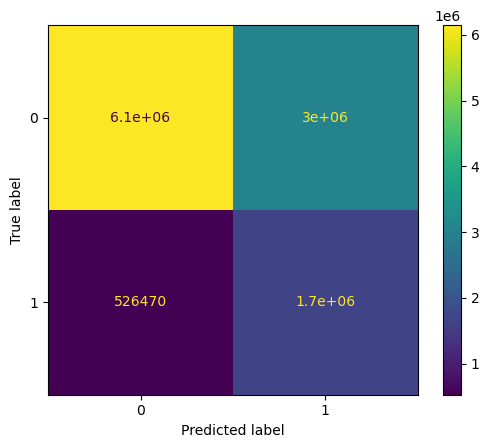

In [29]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

# Confusion Matrix

In [27]:
# Predictions for train data
y_pred_train = best_model.predict(X_train)

In [28]:
# Confusion matrix and classification report for train data
train_cm = confusion_matrix(y_train, y_pred_train)
train_cr = classification_report(y_train, y_pred_train)
print("Training confusion matrix:")
print(train_cm)
print("Training classification report:")
print(train_cr)

Training confusion matrix:
[[14341028  7089417]
 [ 1228126  3909994]]
Training classification report:
              precision    recall  f1-score   support

           0       0.92      0.67      0.78  21430445
           1       0.36      0.76      0.48   5138120

    accuracy                           0.69  26568565
   macro avg       0.64      0.72      0.63  26568565
weighted avg       0.81      0.69      0.72  26568565



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_estimator(
        brfc,
        X_test,
        y_test,
        cmap=plt.cm.Blues)

title = disp.ax_.set_title("Confusion matrix")

print(title)
print(disp.confusion_matrix)

plt.show()

/tmp/ipykernel_3535282/2283730908.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([item[0] for item in sorted_features], rotation=45, ha='right')


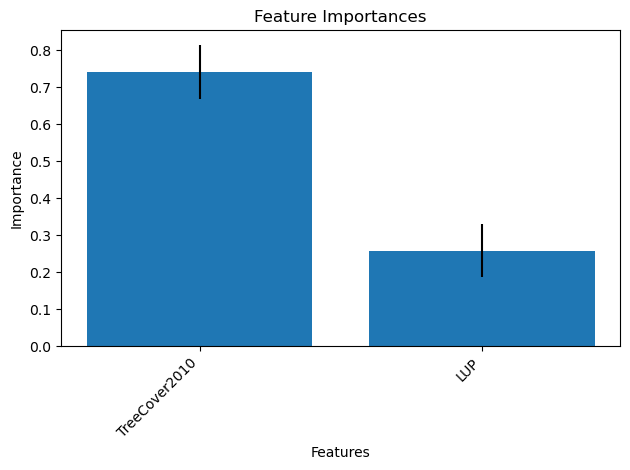

In [33]:
# Calculate feature importances and the standard deviation for those importances
importances = best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)


 # list of feature names corresponding to the input bands of your raster stack
feature_names = ['TreeCover2010','LUP']
# Create a sorted list of tuples containing feature names and their importances:
sorted_features = sorted(zip(feature_names, importances, std), key=lambda x: x[1], reverse=True)

# Create a bar chart
fig, ax = plt.subplots()

# Set the feature names as x-axis labels
ax.set_xticklabels([item[0] for item in sorted_features], rotation=45, ha='right')
ax.set_xticks(range(len(sorted_features)))

# Set the y-axis labels as importances
ax.bar(range(len(sorted_features)), [item[1] for item in sorted_features], yerr=[item[2] for item in sorted_features])

# Set the title and labels for the chart
ax.set_title('Feature Importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importance')

# Display the chart
plt.tight_layout()
plt.show()


# Probabilities for deforestation

In [43]:
y_proba_curve = best_model.predict_proba(X_test)[:, 1]


In [46]:
print("Shape of y_proba_curve:", y_proba_curve.shape)

Shape of y_proba_curve: (11386529,)


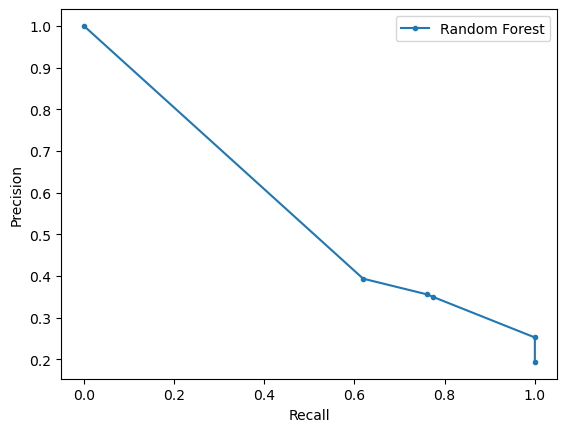

Area under Precision-Recall curve: 0.5569854569566302


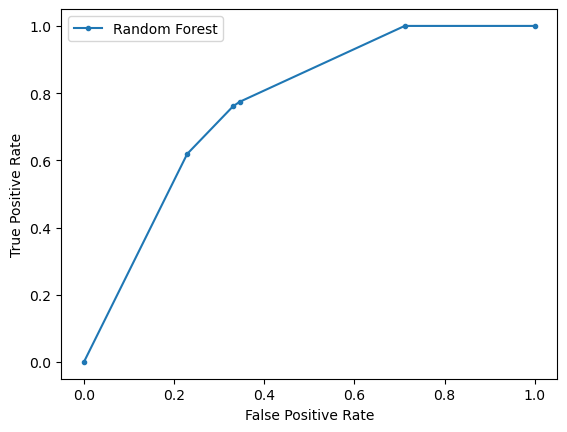

Area under ROC curve: 0.7656242397606493


In [47]:
# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba_curve)
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

print(f"Area under Precision-Recall curve: {auc(recall, precision)}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_curve)
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print(f"Area under ROC curve: {auc(fpr, tpr)}")

In [34]:
# Predict probabilities for deforestation events
y_proba = best_model.predict_proba(X_cleaned)[:, 1]


In [35]:
# Predicts the 
# Create a probability raster by filling in the valid pixel values
prob_raster = np.full(y.shape, no_data_value, dtype=np.float32)
prob_raster[valid_rows] = y_proba
prob_raster = prob_raster.reshape(feature_data_arrays[0].shape)


In [48]:
print(y_proba.shape)

(37955094,)


In [50]:
# Save the probability raster as a GeoTIFF file
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_file = os.path.join(output_folder, "deforestation_prob_balanced.tiff")

with rasterio.open(y_file) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1)

prob_raster_reshaped = prob_raster.reshape((1, prob_raster.shape[0], prob_raster.shape[1]))

with rasterio.open(output_file, 'w', **profile) as dst:
    dst.write_band(1, prob_raster_reshaped[0])




# Tuning Strategies

In [ ]:
# Randomized Search
# Set the range of values for each hyperparameter
'''param_dist = {
    "n_estimators": sp_randint(100, 300),
    'criterion': ['gini',],
    'max_features': ['sqrt', None],
    "max_depth": sp_randint(1, 20),
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(1, 11),
    "bootstrap": [True],
    'class_weight': ['balanced']
}

# Instantiate the RandomForestClassifier
clf = RandomForestClassifier(random_state=0)

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=20, cv=5, random_state=0, n_jobs=19
)'''


'param_dist = {\n    "n_estimators": sp_randint(100, 300),\n    \'criterion\': [\'gini\',],\n    \'max_features\': [\'sqrt\', None],\n    "max_depth": sp_randint(1, 20),\n    "min_samples_split": sp_randint(2, 11),\n    "min_samples_leaf": sp_randint(1, 11),\n    "bootstrap": [True],\n    \'class_weight\': [\'balanced\']\n}\n\n# Instantiate the RandomForestClassifier\nclf = RandomForestClassifier(random_state=0)\n\n# Set up the RandomizedSearchCV\nrandom_search = RandomizedSearchCV(\n    clf, param_distributions=param_dist, n_iter=20, cv=5, random_state=0, n_jobs=19\n)'